# Install the required packages

In [ ]:
!pip install transformers sentencepiece

# Load the LoolooOCR model

In [3]:
import torch

device = "cpu"
# Use mps if available
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"

In [4]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

checkpoint_name = "models/trocr-21m-ep15-finetuned-universal-v3_1"

model = VisionEncoderDecoderModel.from_pretrained(checkpoint_name).to(device)
processor = TrOCRProcessor.from_pretrained(checkpoint_name)

/Users/nim/miniforge3/envs/skooldio/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


# Load the text detector model

In [1]:
from easyocr import Reader

detector = Reader([])

/Users/nim/miniforge3/envs/skooldio/lib/python3.12/site-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(tor

# Load document

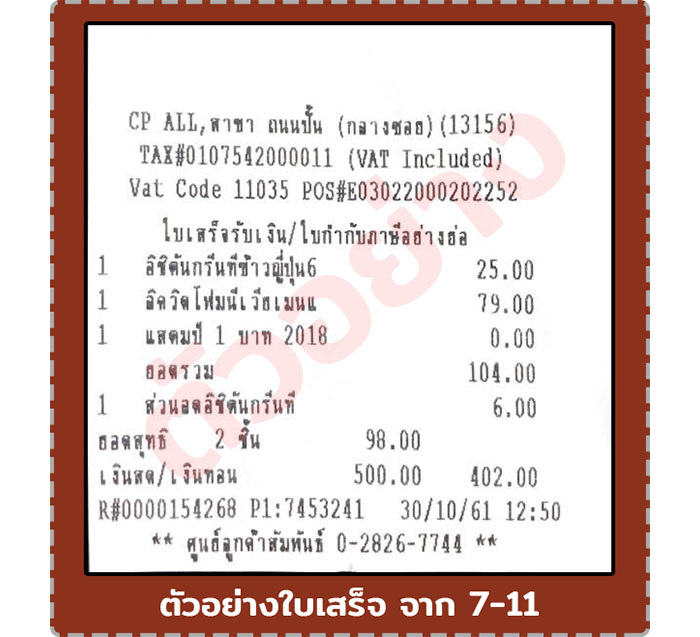

In [5]:
from PIL import Image

image = Image.open("assets/7-11_bill.jpeg").convert("RGB")

display(image)

# Run the text detector
We need to get all the bounding boxes of text before passing it into the recognizer.

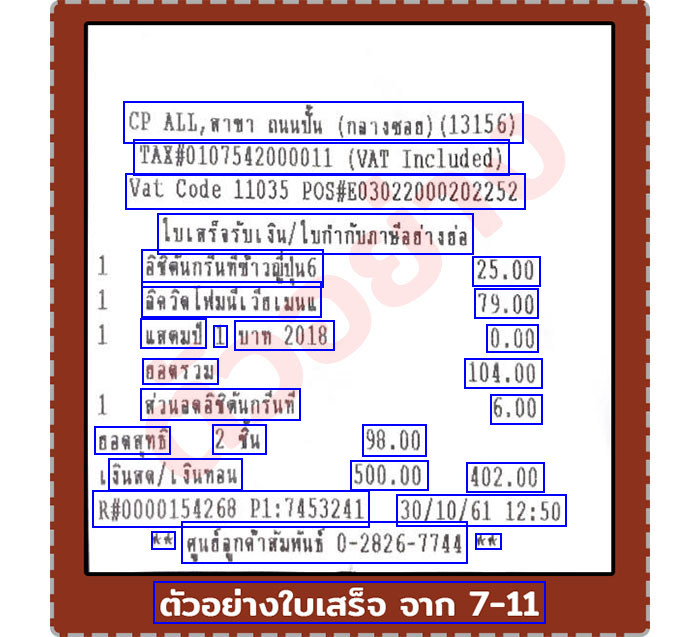

In [11]:
from PIL import ImageDraw

drawn_image = image.copy()
draw = ImageDraw.Draw(drawn_image)

batch_regions, _ = detector.detect("assets/7-11_bill.jpeg")

# Becase we only pass in one image, get the first one.
regions = batch_regions[0]

textboxes = []

# Crop the textbox from the image
for region in regions:
    # Rearrange the region to match the PIL.Image.crop format
    region = [region[0], region[2], region[1], region[3]]

    # Draw the region on the image
    draw.rectangle(region, outline="blue", width=2)

    textbox = image.crop(region)
    textboxes.append(textbox)

display(drawn_image)

Let's display some of the example 

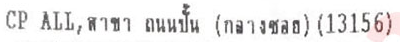

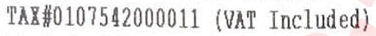

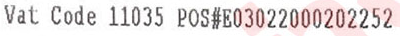

In [13]:
for idx, textbox in enumerate(textboxes):
    if idx >= 3:
        break
    display(textbox)

# Run inference

In [17]:
from tqdm import tqdm

batch_size = 4

# Get divmode
quotient, remainder = divmod(len(textboxes), batch_size)
total_batches = quotient + (1 if remainder > 0 else 0)

predictions = []

for idx in tqdm(range(total_batches), desc="Batch Inferencing"):
    image_batch = textboxes[idx * batch_size : (idx + 1) * batch_size]

    pixel_values = processor(image_batch, return_tensors="pt").pixel_values

    outputs = model.generate(pixel_values.to(device))

    # Decode the prediction
    batch_predictions = processor.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend(batch_predictions)

Batch Inferencing: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


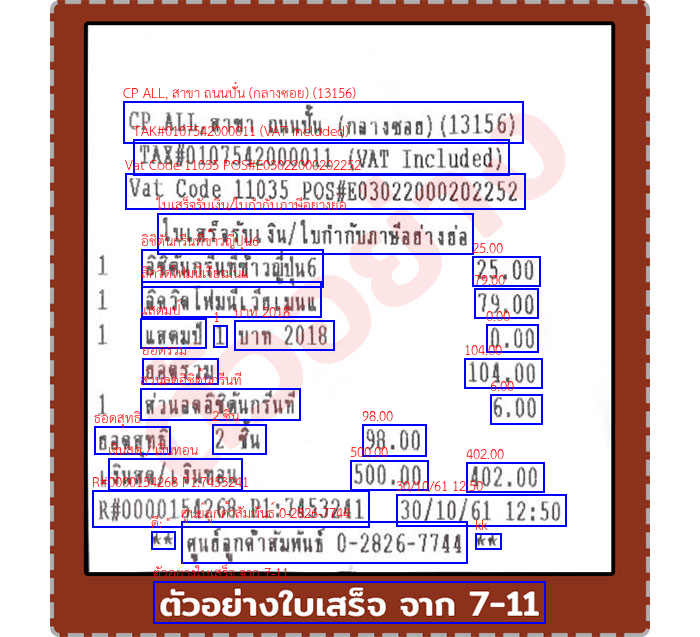

In [25]:
from PIL import ImageDraw, ImageFont

FONT  = ImageFont.truetype("assets/THSarabun.ttf", 20)
label_offset = 20

drawn_image = image.copy()
draw = ImageDraw.Draw(drawn_image)

for region, prediction in zip(regions, predictions):
    region = [region[0], region[2], region[1], region[3]]
    draw.rectangle(region, outline="blue", width=2)
    draw.text((region[0], region[1] - label_offset), prediction, fill="red", font=FONT)

display(drawn_image)
